### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [1]:
# !mkdir -p data
#
# !cd data && wget http://images.cocodataset.org/zips/train2017.zip
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#
# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip

# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && make

### Импорт необходимых библиотек

In [2]:
import os
import skimage.io as io
import numpy as np
from livelossplot.tf_keras import PlotLossesCallback
from pathlib import Path
import imageio

%matplotlib inline
import matplotlib.pyplot as plt

### Импорт TensorFlow

In [3]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow version: 2.4.1


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котором не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

input_size = 256
batch_size = 16
epochs = 250

train_ds = COCO_dataset_train.train_dataset(epochs=epochs, inp_size=input_size, batch_size=batch_size)
val_ds = COCO_dataset_val.val_dataset(inp_size=input_size, batch_size=batch_size)

loading annotations into memory...
Done (t=14.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [8]:
def build_model():
    x = tf.keras.layers.Input((input_size, input_size, 3))

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=(2, 2))(out1)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', strides=(2, 2))(out2)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', strides=(2, 2))(out3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', strides=(2, 2))(out4)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.UpSampling2D((2, 2))(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.UpSampling2D((2, 2))(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.UpSampling2D((2, 2))(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.UpSampling2D((2, 2))(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

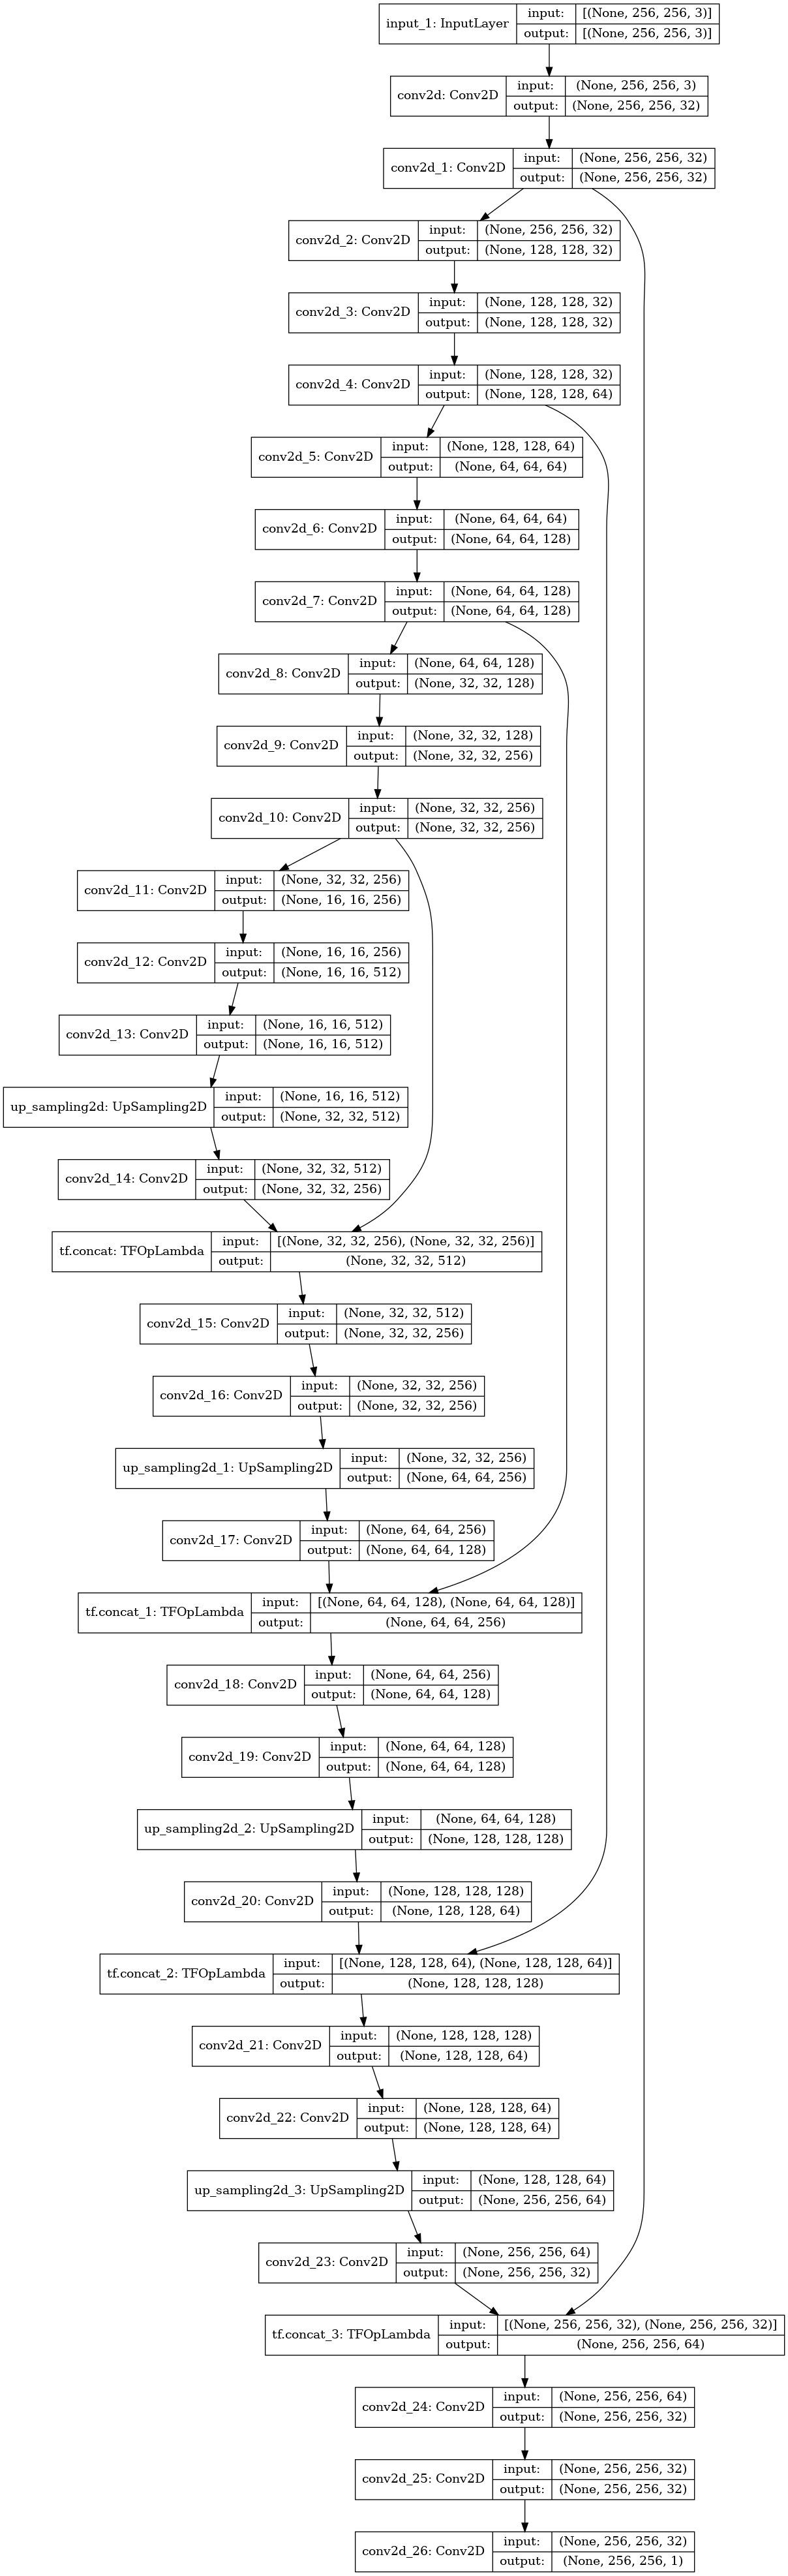

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(lr=0.0001)

In [11]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [12]:
path = Path("model_coco")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, 
                                                save_weights_only=True, save_best_only=True, mode='max')

Обучим модель в течение 250 эпох.

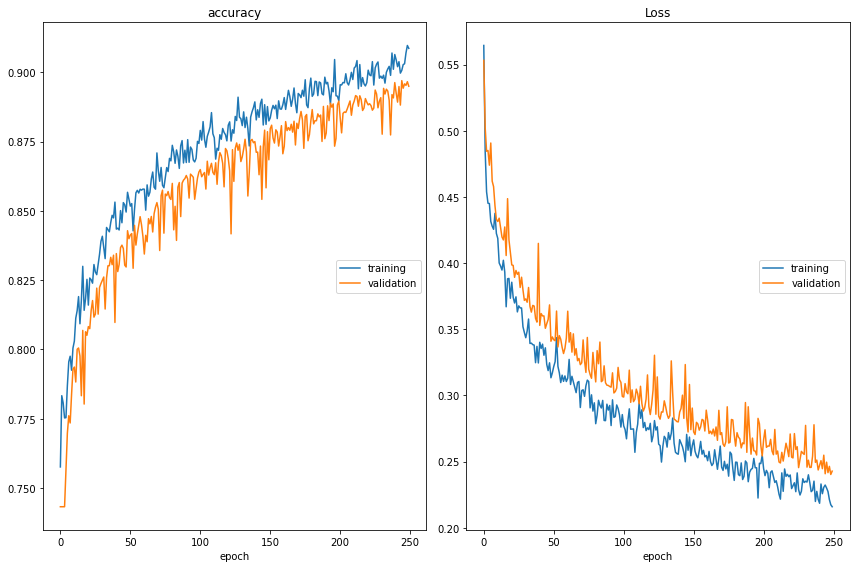

accuracy
	training         	 (min:    0.758, max:    0.910, cur:    0.909)
	validation       	 (min:    0.743, max:    0.897, cur:    0.895)
Loss
	training         	 (min:    0.216, max:    0.564, cur:    0.216)
	validation       	 (min:    0.240, max:    0.553, cur:    0.243)

Epoch 00250: val_accuracy did not improve from 0.89697


In [13]:
history = model.fit(x=train_ds, validation_data=val_ds, callbacks=[PlotLossesCallback(), checkpoint], 
                    epochs=epochs, steps_per_epoch=100)

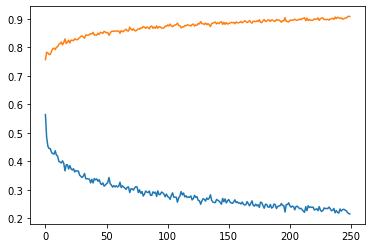

In [14]:
if history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])

На графиках виден потенциал для дальнейшего роста. Доучим модель ещё в течение 250 эпох.

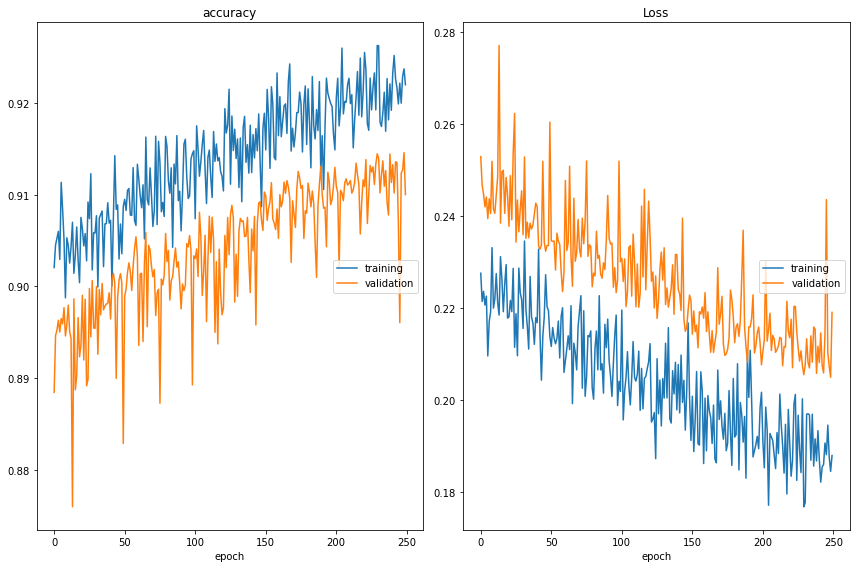

accuracy
	training         	 (min:    0.899, max:    0.926, cur:    0.922)
	validation       	 (min:    0.876, max:    0.915, cur:    0.910)
Loss
	training         	 (min:    0.177, max:    0.235, cur:    0.188)
	validation       	 (min:    0.205, max:    0.277, cur:    0.219)

Epoch 00250: val_accuracy did not improve from 0.91459


In [22]:
history = model.fit(x=train_ds, validation_data=val_ds, callbacks=[PlotLossesCallback(), checkpoint], 
                    epochs=epochs, steps_per_epoch=100)

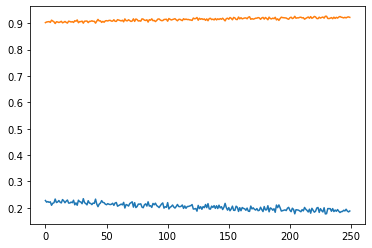

In [23]:
if history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])

Судя по графику, максимальный потенциал роста практически дотигнут. Проведём дополнительное обучение длительностью 50 эпох.

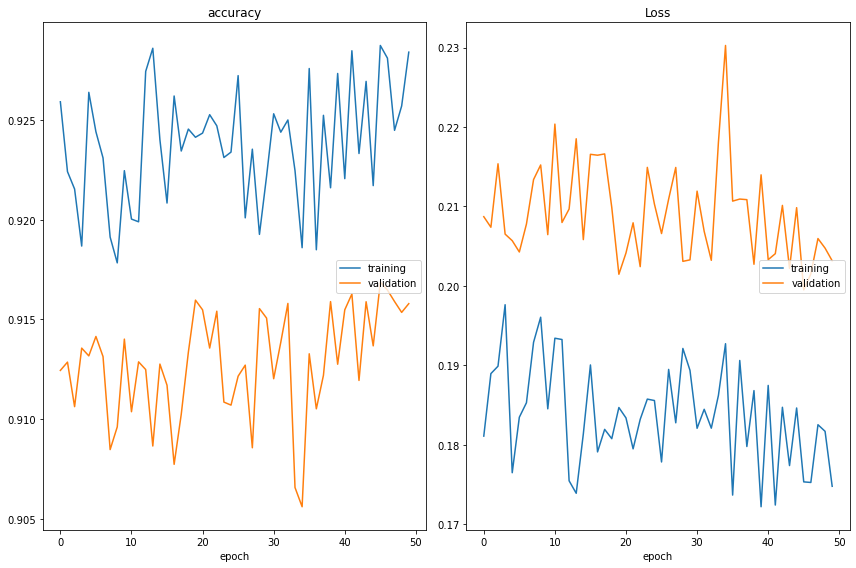

accuracy
	training         	 (min:    0.918, max:    0.929, cur:    0.928)
	validation       	 (min:    0.906, max:    0.917, cur:    0.916)
Loss
	training         	 (min:    0.172, max:    0.198, cur:    0.175)
	validation       	 (min:    0.200, max:    0.230, cur:    0.203)

Epoch 00050: val_accuracy did not improve from 0.91687


In [31]:
history = model.fit(x=train_ds, validation_data=val_ds, callbacks=[PlotLossesCallback(), checkpoint], 
                    epochs=50, steps_per_epoch=100)

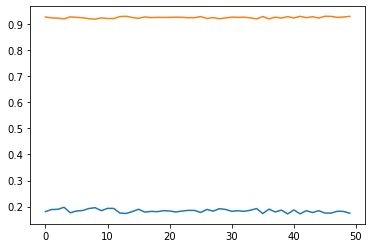

In [32]:
if history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])

In [33]:
model.load_weights(str(cpt_path))
model.evaluate(val_ds)

168/168 [==============================] - 29s 174ms/step - loss: 0.1995 - accuracy: 0.9169


[0.19950631260871887, 0.9168734550476074]

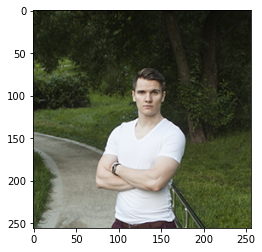

In [34]:
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

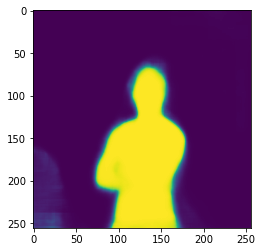

In [35]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

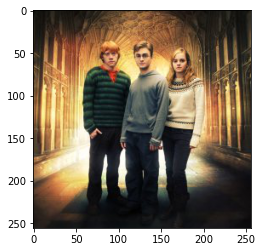

In [36]:
img2 = imageio.imread('HP.jpg')
img2 = img2.astype(np.float32) / 255.
_=plt.imshow(img2)

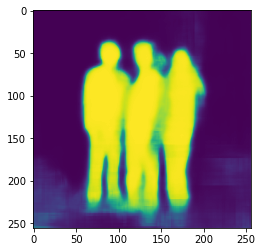

In [37]:
out = model.predict(img2[None, ...])[0, ...]
_=plt.imshow(out[...,0])